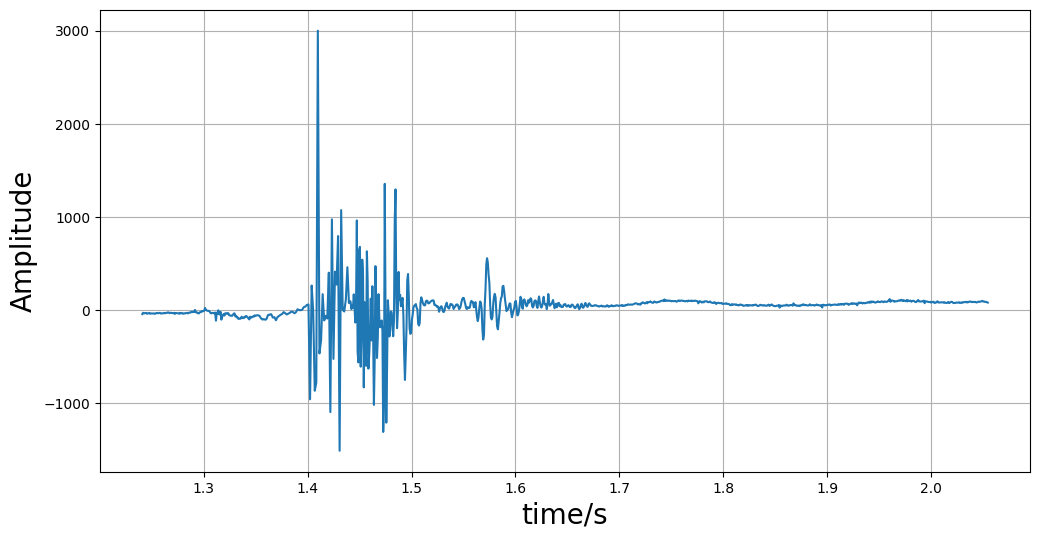

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker
import pandas as pd
 
#这是一个画图函数，方便后续作图
def personal_plot(x,y):
    plt.figure(figsize=(12,6))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.plot(x,y)
    # plt.xlim(x[0],x[-1])
    plt.xlabel('time/s',fontsize=20)
    plt.ylabel('Amplitude',fontsize=20)
    plt.grid()
 
#注意如果文件名不加路径，则文件必须存在于python的工作目录中
df = pd.read_csv('./output_processed/20240104_091258.csv')
y = df['ACC_X']
t = df['Time']
# sr = int(1/np.mean(np.diff(t)))
sr=1300

#这里只获取0-20秒的部分，这里也可以在上一步的load函数中令duration=20来实现
tmax,tmin = 1.1,0.3
# t = np.linspace(tmin,tmax,(tmax-tmin)*sr)
start_index = int(tmin*sr)
end_index = int(tmax*sr)
personal_plot(t[start_index:end_index],y[start_index:end_index])

Text(0.5, 0, 'Frequency/Hz')

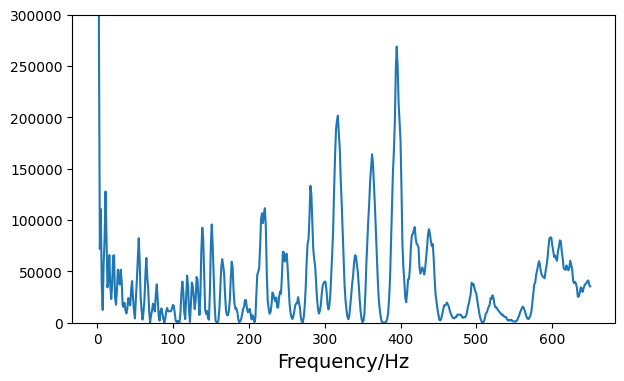

In [35]:
alpha = 0.97
emphasized_y = np.append(y[start_index],y[start_index+1:end_index]-alpha*y[start_index:end_index-1])
n = int((tmax-tmin)*sr) #信号一共的sample数量
 
#未经过预加重的信号频谱
plt.figure(figsize=(7,4))
freq = sr/n*np.linspace(0,n/2,int(n/2)+1)
plt.plot(freq,np.absolute(np.fft.rfft(y[start_index:end_index],n)**2)/n)
range_y = 300000
plt.ylim(0,range_y)
plt.xlabel('Frequency/Hz',fontsize=14)

Text(0.5, 0, 'Frequency/Hz')

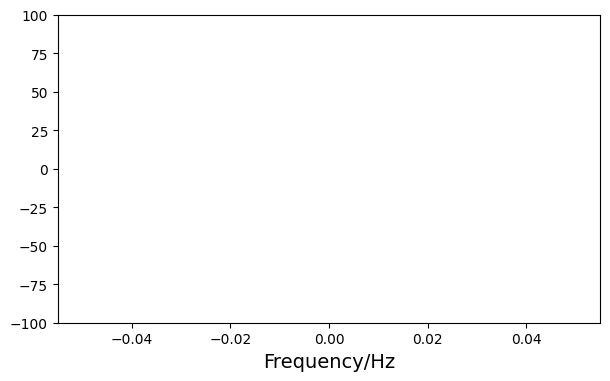

In [44]:
#预加重之后的信号频谱
plt.figure(figsize=(7,4))
plt.plot(freq,np.absolute(np.fft.rfft(emphasized_y,n)**2)/n)
# plt.xlim(0,5000)
plt.ylim(-100,100)

plt.xlabel('Frequency/Hz',fontsize=14)
# print(emphasized_y)